**anomaly detection**

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sb 
from scipy.io import loadmat 

In [2]:
data = loadmat('data/ex8data1.mat')
X = data['X']
X.shape

(307, 2)

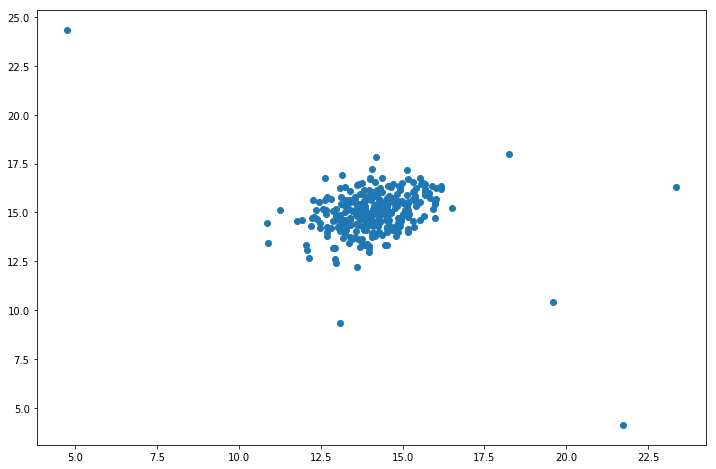

In [3]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])
plt.show()

### 创建生成均值和方差的函数

In [6]:
def estimate_gaussian(X):
    mu = X.mean(axis = 0)
    sigma = X.var(axis = 0)
    return mu ,sigma

In [7]:
mu , sigma = estimate_gaussian(X)
mu , sigma 

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

In [9]:
Xval = data['Xval']
yval = data['yval']

Xval.shape ,yval.shape

((307, 2), (307, 1))

In [10]:
# 计算一种数据点属于正态分布的概率的方法。scipy 自带
from scipy import stats
dist = stats.norm(mu[0],sigma[0])
dist.pdf(15)

0.1935875044615038

In [11]:
#将数据组传递给概率密度函数，并获得数据集中每个点的概率密度
dist.pdf(X[:,0])[0:50]

array([0.183842  , 0.20221694, 0.21746136, 0.19778763, 0.20858956,
       0.21652359, 0.16991291, 0.15123542, 0.1163989 , 0.1594734 ,
       0.21716057, 0.21760472, 0.20141857, 0.20157497, 0.21711385,
       0.21758775, 0.21695576, 0.2138258 , 0.21057069, 0.1173018 ,
       0.20765108, 0.21717452, 0.19510663, 0.21702152, 0.17429399,
       0.15413455, 0.21000109, 0.20223586, 0.21031898, 0.21313426,
       0.16158946, 0.2170794 , 0.17825767, 0.17414633, 0.1264951 ,
       0.19723662, 0.14538809, 0.21766361, 0.21191386, 0.21729442,
       0.21238912, 0.18799417, 0.21259798, 0.21752767, 0.20616968,
       0.21520366, 0.1280081 , 0.21768113, 0.21539967, 0.16913173])

In [13]:
#保存上述的高斯模型参数的数据集
p = np.zeros((X.shape[0],X.shape[1]))
p[:,0] = stats.norm(mu[0],sigma[0]).pdf(X[:,0])
p[:,1] = stats.norm(mu[1],sigma[0]).pdf(X[:,1])
p.shape

(307, 2)

In [14]:
#验证集进行同样操作
pval = np.zeros((Xval.shape[0],Xval.shape[1]))
pval[:,0] = stats.norm(mu[0],sigma[0]).pdf(Xval[:,0])
pval[:,1] = stats.norm(mu[1],sigma[1]).pdf(Xval[:,1])
pval.shape

(307, 2)

## 计算F1
<img style="float: left;" src="../img/f1_score.png">

In [16]:
def select_threshold(pval,yval):
    best_epsilon = 0 
    best_f1 = 0
    f1 = 0 
    step = (pval.max() - pval.min()) / 1000
    for epsilon in np.arange(pval.min(),pval.max(),step):
        preds = pval < epsilon 
        tp = np.sum(np.logical_and(preds == 1,yval == 1)).astype(float)
        fp = np.sum(np.logical_and(preds == 1,yval == 0)).astype(float)
        fn = np.sum(np.logical_and(preds == 0,yval == 1)).astype(float)
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2 * precision * recall) / (precision + recall)
        
        if f1 > best_f1:
            best_f1 = f1 
            best_epsilon = epsilon
    return best_epsilon, best_f1

In [18]:
epsilon,f1 = select_threshold(pval,yval)
epsilon, f1

F:\Anaconda\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


(0.009566706005956842, 0.7142857142857143)

In [19]:
#将阈值应用于数据集
outliers = np.where(p < epsilon)
outliers

(array([300, 301, 301, 303, 303, 304, 306, 306], dtype=int64),
 array([1, 0, 1, 0, 1, 0, 0, 1], dtype=int64))

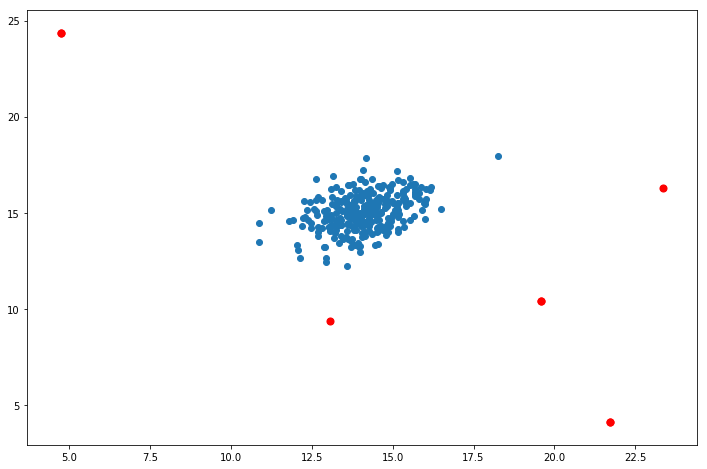

In [20]:
fig, ax = plt.subplots(figsize = (12,8))
ax.scatter(X[:,0],X[:,1])
ax.scatter(X[outliers[0],0],X[outliers[0],1],s=50,color='r',marker='o')
plt.show()

红色点为标记出来的点

## 协同过滤

这个就是推荐电影的算法！！

In [21]:
data = loadmat('data/ex8_movies.mat')
data

{'R': array([[1, 1, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'Y': array([[5, 4, 0, ..., 5, 0, 0],
        [3, 0, 0, ..., 0, 0, 5],
        [4, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 17:19:26 2011',
 '__version__': '1.0'}

In [22]:
# Y 表示电影的评分，R表示电影有没有评分
Y = data['Y']
R = data['R']
Y.shape, R.shape

((1682, 943), (1682, 943))

In [23]:
# 通过平均排序Y来评估电影的平均评级
Y[1,np.where(R[1,:]==1)[0]].mean()

3.2061068702290076

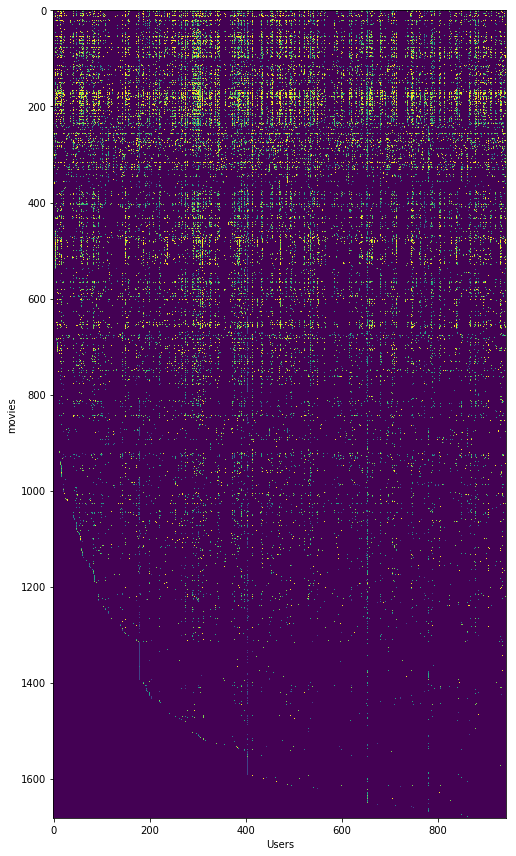

In [24]:
# 矩阵渲染图
fig,ax = plt.subplots(figsize=(12,12))
ax.imshow(Y)
ax.set_xlabel('Users')
ax.set_ylabel('movies')
fig.tight_layout()
plt.show()

# cost
<img style="float: left;" src="../img/rcmd_cost.png">

In [33]:
def cost(params, Y, R, num_features):
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    
    # initializations
    J = 0
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    return J

In [34]:
# 使用预参数训练
params_data = loadmat('data/ex8_movieParams.mat')
X = params_data['X']
Theta = params_data['Theta']
X.shape, Theta.shape

((1682, 10), (943, 10))

In [35]:
users = 4
movies = 5
features = 3

X_sub = X[:movies,:features]
Theta_sub = Theta[:users,:features]
Y_sub = Y[:movies,:users]
R_sub = R[:movies,:users]
params = np.concatenate((np.ravel(X_sub),np.ravel(Theta_sub)))
cost(params,Y_sub,R_sub,features)

22.224603725685675

# gradient
<img style="float: left;" src="../img/rcmd_gradient.png">

In [36]:
# 扩展代价函数
def cost(params,Y,R,num_features):
    Y = np.matrix(Y)
    R = np.matrix(R)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    
    # initializations
    J = 0
    X_grad = np.zeros(X.shape)  # (1682, 10)
    Theta_grad = np.zeros(Theta.shape)  # (943, 10)
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    # calculate the gradients
    X_grad = error * Theta 
    Theta_grad = error.T * X 
    
    grad = np.concatenate((np.ravel(X_grad),np.ravel(Theta_grad)))
    
    return J,grad
    
    

In [37]:
J ,grad = cost(params,Y_sub,R_sub,features)
J ,grad

(22.224603725685675,
 array([ -2.52899165,   7.57570308,  -1.89979026,  -0.56819597,
          3.35265031,  -0.52339845,  -0.83240713,   4.91163297,
         -0.76677878,  -0.38358278,   2.26333698,  -0.35334048,
         -0.80378006,   4.74271842,  -0.74040871, -10.5680202 ,
          4.62776019,  -7.16004443,  -3.05099006,   1.16441367,
         -3.47410789,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ]))

### 带正则化

<img style="float: left;" src="../img/rcmd_reg_grad.png">

In [39]:
def cost(params,Y,R,num_features,learning_rate):
    Y = np.matrix(Y)
    R = np.matrix(R)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    
    # initializations
    J = 0
    X_grad = np.zeros(X.shape)  # (1682, 10)
    Theta_grad = np.zeros(Theta.shape)  # (943, 10)
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    J = J + ((learning_rate / 2) * np.sum(np.power(Theta,2)))
    J = J + ((learning_rate / 2) * np.sum(np.power(X,2)))
    
    # calculate the gradients
    X_grad = (error * Theta) + (learning_rate * X) 
    Theta_grad = (error.T * X ) + (learning_rate * Theta)
    
    grad = np.concatenate((np.ravel(X_grad),np.ravel(Theta_grad)))
    
    return J,grad

In [40]:
J ,grad = cost(params,Y_sub,R_sub,features,1.5)
J ,grad

(31.34405624427422,
 array([ -0.95596339,   6.97535514,  -0.10861109,   0.60308088,
          2.77421145,   0.25839822,   0.12985616,   4.0898522 ,
         -0.89247334,   0.29684395,   1.06300933,   0.66738144,
          0.60252677,   4.90185327,  -0.19747928, -10.13985478,
          2.10136256,  -6.76563628,  -2.29347024,   0.48244098,
         -2.99791422,  -0.64787484,  -0.71820673,   1.27006666,
          1.09289758,  -0.40784086,   0.49026541]))

## 创建自己的电影评分

In [42]:
movie_idx = {}
f = open('data/movie_ids.txt',encoding = 'gbk')
for line  in  f:
    tokens = line.split(' ')
    tokens[-1] = tokens[-1][:-1]
    movie_idx[int(tokens[0]) - 1] =  ' '.join(tokens[1:])
    

In [43]:
movie_idx[0]

'Toy Story (1995)'

In [45]:
ratings = np.zeros((1682,1))
ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

print('Rated {0} with {1} stars.'.format(movie_idx[0], str(int(ratings[0]))))
print('Rated {0} with {1} stars.'.format(movie_idx[6], str(int(ratings[6]))))
print('Rated {0} with {1} stars.'.format(movie_idx[11], str(int(ratings[11]))))
print('Rated {0} with {1} stars.'.format(movie_idx[53], str(int(ratings[53]))))
print('Rated {0} with {1} stars.'.format(movie_idx[63], str(int(ratings[63]))))
print('Rated {0} with {1} stars.'.format(movie_idx[65], str(int(ratings[65]))))
print('Rated {0} with {1} stars.'.format(movie_idx[68], str(int(ratings[68]))))
print('Rated {0} with {1} stars.'.format(movie_idx[97], str(int(ratings[97]))))
print('Rated {0} with {1} stars.'.format(movie_idx[182], str(int(ratings[182]))))
print('Rated {0} with {1} stars.'.format(movie_idx[225], str(int(ratings[225]))))
print('Rated {0} with {1} stars.'.format(movie_idx[354], str(int(ratings[354]))))

Rated Toy Story (1995) with 4 stars.
Rated Twelve Monkeys (1995) with 3 stars.
Rated Usual Suspects, The (1995) with 5 stars.
Rated Outbreak (1995) with 4 stars.
Rated Shawshank Redemption, The (1994) with 5 stars.
Rated While You Were Sleeping (1995) with 3 stars.
Rated Forrest Gump (1994) with 5 stars.
Rated Silence of the Lambs, The (1991) with 2 stars.
Rated Alien (1979) with 4 stars.
Rated Die Hard 2 (1990) with 5 stars.
Rated Sphere (1998) with 5 stars.


添加自己的评分进去

In [47]:
R = data['R']
Y = data['Y']
Y = np.append(Y,ratings,axis=1)
R = np.append(R,ratings != 0,axis = 1)
Y.shape,R.shape,ratings.shape

((1682, 944), (1682, 944), (1682, 1))

In [49]:
movies = Y.shape[0]
users = Y.shape[1]
features = 10 
learning_rate = 10 

X = np.random.random(size=(movies,features))
Theta = np.random.random(size=(users,features))
params = np.concatenate((np.ravel(X),np.ravel(Theta)))

X.shape,Theta.shape,params.shape

((1682, 10), (944, 10), (26260,))

In [50]:
Ymean = np.zeros((movies,1))
Ynorm = np.zeros((movies,users))

for i in  range(movies):
    idx = np.where(R[i,:]==1)[0]
    Ymean[i] = Y[i,idx].mean()
    Ynorm[i,idx] = Y[i,idx] - Ymean[i]
    
Ynorm.mean()

5.507036456515984e-19

In [64]:
from scipy.optimize import minimize 

fmin = minimize(fun=cost,x0=params,args=(Ynorm,R,features,learning_rate),
               method = 'CG',jac = True)
fmin

     fun: 38951.84755998261
     jac: array([ 1.16334285e-06, -3.42028922e-07,  9.22049560e-07, ...,
        1.77003006e-08,  5.50881669e-08, -3.45658262e-08])
 message: 'Optimization terminated successfully.'
    nfev: 549
     nit: 365
    njev: 549
  status: 0
 success: True
       x: array([-0.16204655,  0.1511003 , -0.19135648, ...,  0.11800801,
        0.14883019, -0.06339363])

In [65]:
X = np.matrix(np.reshape(fmin.x[:movies*features],(movies,features)))
Theta = np.matrix(np.reshape(fmin.x[movies*features:],(users,features)))

X.shape,Theta.shape

((1682, 10), (944, 10))

In [66]:
predictions = X *Theta.T
my_preds = predictions[:,-1] + Ymean
my_preds.shape

(1682, 1)

In [67]:
idx = np.argsort(my_preds,axis=0)[::-1]

In [68]:
idx

matrix([[1499],
        [1292],
        [1188],
        ...,
        [1581],
        [1625],
        [1485]], dtype=int64)

In [69]:
print ("top 10 movie predictions:")
for  i  in  range(10):
    j = int(idx[i])
    print ('Predicted rating of {0} for movie {1}'.format(str(float(my_preds[j])),movie_idx[j]))

top 10 movie predictions:
Predicted rating of 5.000000000026491 for movie Santa with Muscles (1996)
Predicted rating of 5.000000000016069 for movie Star Kid (1997)
Predicted rating of 4.99999999999946 for movie Prefontaine (1997)
Predicted rating of 4.999999999996897 for movie They Made Me a Criminal (1939)
Predicted rating of 4.999999999989064 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicted rating of 4.999999999980689 for movie Saint of Fort Washington, The (1993)
Predicted rating of 4.999999999974442 for movie Marlene Dietrich: Shadow and Light (1996) 
Predicted rating of 4.9999999999741584 for movie Aiqing wansui (1994)
Predicted rating of 4.999999999972606 for movie Great Day in Harlem, A (1994)
Predicted rating of 4.9999999999706874 for movie Someone Else's America (1995)
